In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Lambda, SimpleRNN, LSTM

In [2]:
def evaluate_model(model, X_val, y_val):
    forecast_val = model.predict(X_val)
    mae_val = mean_absolute_error(y_val, forecast_val)
    mse_val = mean_squared_error(y_val, forecast_val)
    return mae_val, mse_val

def plot_predictions(forecast_val, y_val, title="Baseline model plot", start_date=None, end_date=None):
    plt.figure(figsize=(10, 6))

    plt.plot(forecast_val, label='Predicted Validation')
    plt.plot(y_val, label='Actual Validation')
    if start_date and end_date:
        start_idx = df.index.get_loc(pd.Timestamp(start_date))
        end_idx = df.index.get_loc(pd.Timestamp(end_date))
        start_idx -= len(data) - len(y_val)
        end_idx -= len(data) - len(y_val)
        plt.xlim(start_idx, end_idx)
    plt.title(title)
    plt.legend()
    plt.show()






#Data Preparation

In [3]:
# URL of the dataset
url = 'https://raw.githubusercontent.com/PacktPublishing/TensorFlow-Developer-Certificate-Guide/main/Chapter%2012/sales_data.csv'
# Load the dataset
df = pd.read_csv(url)
df.head()

,Date,Sales
0,2013-01-01,48.40
1,2013-01-02,49.63
2,2013-01-03,44.66
3,2013-01-04,56.70
4,2013-01-05,62.87


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df['Sales'].values

# Sliding window
window_size = 20
X, y = [], []
for i in range(window_size, len(data)):
    X.append(data[i-window_size:i])
    y.append(data[i])

X = np.array(X)
y = np.array(y)

# Train/val split
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Reshape data for CNN, LSTM, CNN-LSTM
X_train_cnn = X_train.reshape(-1, window_size, 1)
X_val_cnn = X_val.reshape(-1, window_size, 1)
# Create dataset
batch_size = 128
dataset_cnn = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train))
dataset_cnn = dataset_cnn.shuffle(buffer_size=1000).batch(batch_size)


Note: When building models with CNNs, RNNs, LSTMs and CNN-LSTM networks we can either reshape the data before we feed it into the model or we can use lambda layers to this as well during modelling.

#CNN

In [ ]:
# Build CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')

# Train model
model.fit(dataset_cnn, epochs=100, verbose=0)

23/23 [==============================] - 0s 2ms/step


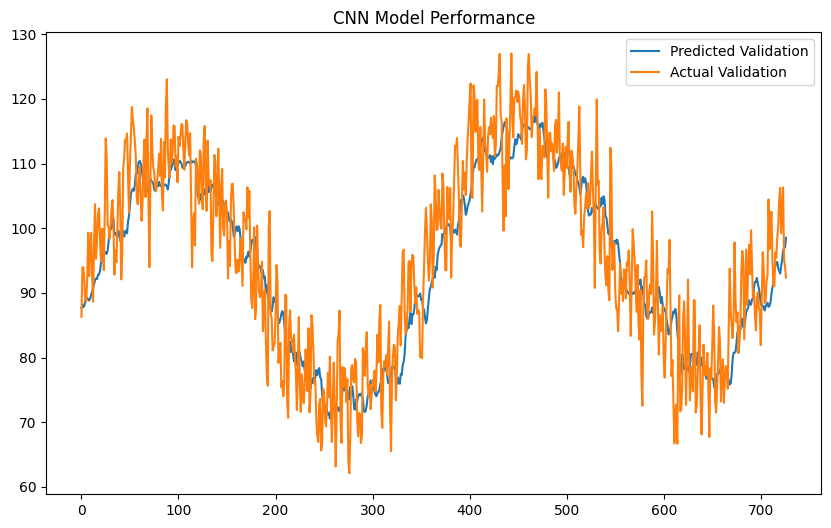

MAE: 5.495691718477985, MSE: 47.439234610942805


In [ ]:
# plot
forecast = model.predict(X_val_cnn)
plot_predictions(forecast, y_val, title="CNN Model Performance")

# evaluate
mae, mse = evaluate_model(model, X_val_cnn, y_val)
print(f'MAE: {mae}, MSE: {mse}')

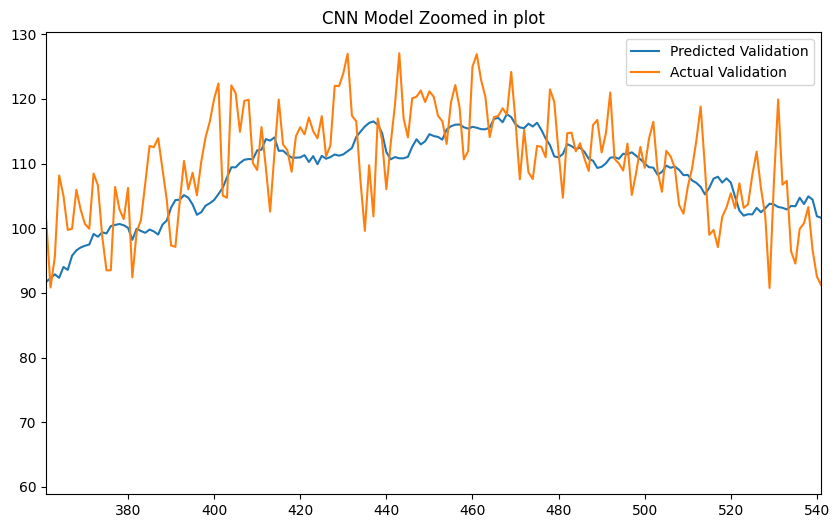

In [ ]:
start_date = "2022-01-01"
end_date = "2022-06-30"
plot_predictions(forecast, y_val, title="CNN Model Zoomed in plot", start_date=start_date, end_date=end_date)


#RNN

In [5]:
# Create dataset
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) #we use X_train not X_train_cnn
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Build RNN model, we use lambda to reshape our data
model = Sequential([Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
                    SimpleRNN(40, return_sequences=True),
                    SimpleRNN(40),
                    Dense(1),
                    Lambda(lambda x: x * 100)])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4), loss='mse')

# Train model
model.fit(dataset, epochs=100)



Epoch 1/100
23/23 [==============================] - 2s 20ms/step - loss: 336.7581
Epoch 2/100
23/23 [==============================] - 0s 20ms/step - loss: 55.9413
Epoch 3/100
23/23 [==============================] - 0s 19ms/step - loss: 45.9125
Epoch 4/100
23/23 [==============================] - 0s 20ms/step - loss: 40.5357
Epoch 5/100
23/23 [==============================] - 0s 16ms/step - loss: 36.6995
Epoch 6/100
23/23 [==============================] - 0s 12ms/step - loss: 34.1898
Epoch 7/100
23/23 [==============================] - 0s 12ms/step - loss: 32.8125
Epoch 8/100
23/23 [==============================] - 0s 12ms/step - loss: 32.9489
Epoch 9/100
23/23 [==============================] - 0s 12ms/step - loss: 34.5792
Epoch 10/100
23/23 [==============================] - 0s 12ms/step - loss: 32.6294
Epoch 11/100
23/23 [==============================] - 0s 12ms/step - loss: 33.0421
Epoch 12/100
23/23 [==============================] - 0s 13ms/step - loss: 31.9572
Epoch 13/100

23/23 [==============================] - 0s 4ms/step


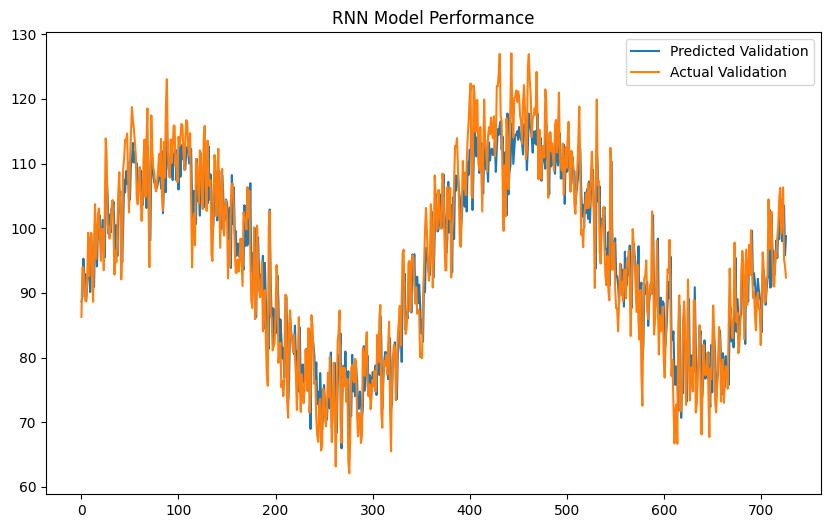

23/23 [==============================] - 0s 3ms/step
MAE: 4.288614618650329, MSE: 28.697197371771985


In [6]:
# plot
forecast = model.predict(X_val)
plot_predictions(forecast, y_val, title="RNN Model Performance")

# evaluate
mae, mse = evaluate_model(model, X_val, y_val)
print(f'MAE: {mae}, MSE: {mse}')


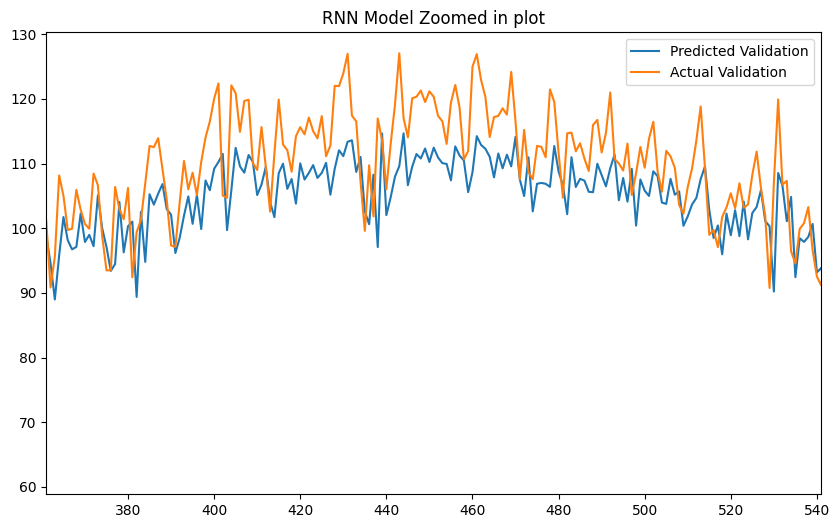

In [ ]:
start_date = "2022-01-01"
end_date = "2022-06-30"
plot_predictions(forecast, y_val, title="RNN Model Zoomed in plot", start_date=start_date, end_date=end_date)


#LSTMs

Epoch 1/100
23/23 [==============================] - 4s 89ms/step - loss: 259.4622
Epoch 2/100
23/23 [==============================] - 1s 40ms/step - loss: 314.6850
Epoch 3/100
23/23 [==============================] - 1s 26ms/step - loss: 87.9791
Epoch 4/100
23/23 [==============================] - 1s 24ms/step - loss: 116.5407
Epoch 5/100
23/23 [==============================] - 1s 26ms/step - loss: 97.0238
Epoch 6/100
23/23 [==============================] - 1s 25ms/step - loss: 131.1522
Epoch 7/100
23/23 [==============================] - 1s 24ms/step - loss: 97.0884
Epoch 8/100
23/23 [==============================] - 1s 25ms/step - loss: 774.2260
Epoch 9/100
23/23 [==============================] - 1s 24ms/step - loss: 135.4747
Epoch 10/100
23/23 [==============================] - 1s 26ms/step - loss: 68.7973
Epoch 11/100
23/23 [==============================] - 1s 25ms/step - loss: 59.8576
Epoch 12/100
23/23 [==============================] - 1s 24ms/step - loss: 50.4273
Epoch 1

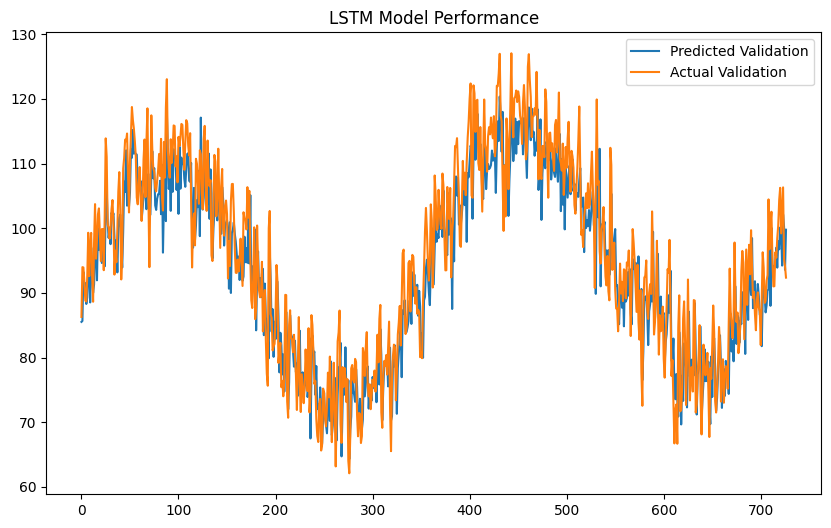

23/23 [==============================] - 0s 4ms/step
MAE: 4.518637843912536, MSE: 32.45035565452138


In [7]:
# Build LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

# Train model
model.fit(dataset_cnn, epochs=100)

# plot
forecast = model.predict(X_val_cnn)
plot_predictions(forecast, y_val, title="LSTM Model Performance")

# evaluate
mae, mse = evaluate_model(model, X_val_cnn, y_val)
print(f'MAE: {mae}, MSE: {mse}')

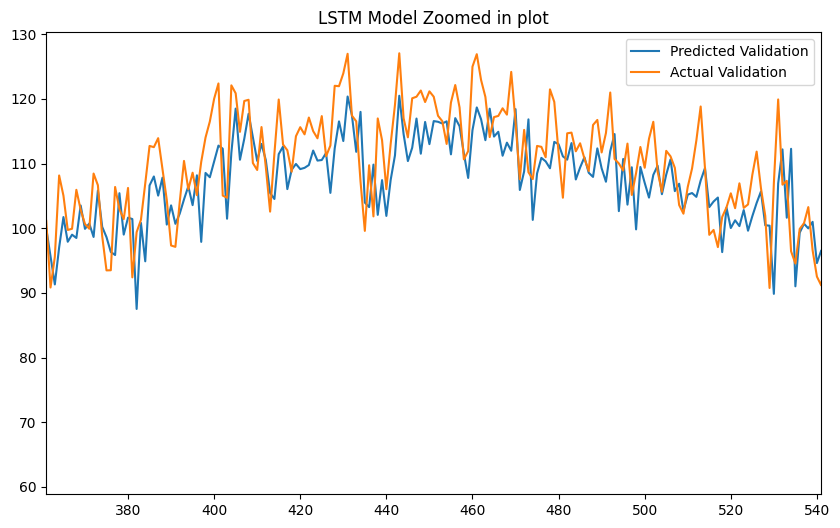

In [8]:
start_date = "2022-01-01"
end_date = "2022-06-30"
plot_predictions(forecast, y_val, title="LSTM Model Zoomed in plot", start_date=start_date, end_date=end_date)


#CNN-LSTM

In [9]:
# Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[window_size, 1]),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1)
])

# Compile model with optimizer and loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4), loss='mse')

# Fit model
history = model.fit(dataset_cnn, epochs=100, verbose=0)




23/23 [==============================] - 1s 8ms/step


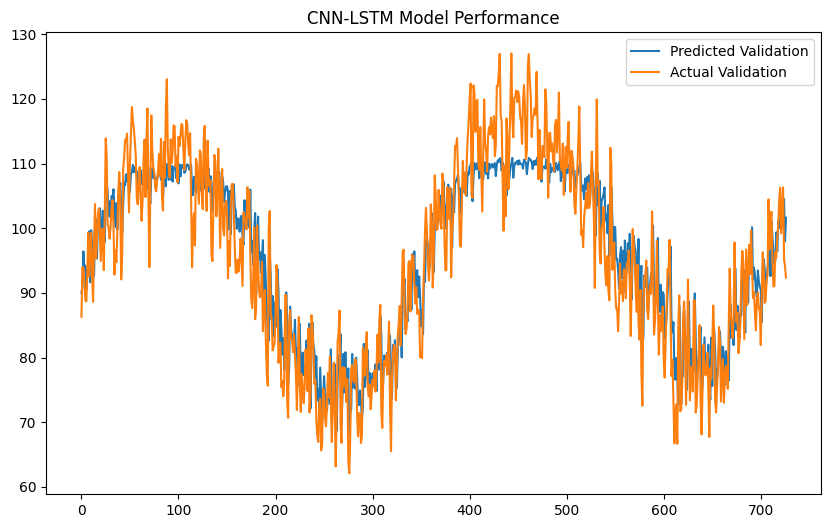

23/23 [==============================] - 0s 10ms/step
MAE: 4.781511756445716, MSE: 35.17083875375134


In [10]:
# plot
forecast = model.predict(X_val_cnn)
plot_predictions(forecast, y_val, title="CNN-LSTM Model Performance")

# evaluate
mae, mse = evaluate_model(model, X_val_cnn, y_val)
print(f'MAE: {mae}, MSE: {mse}')

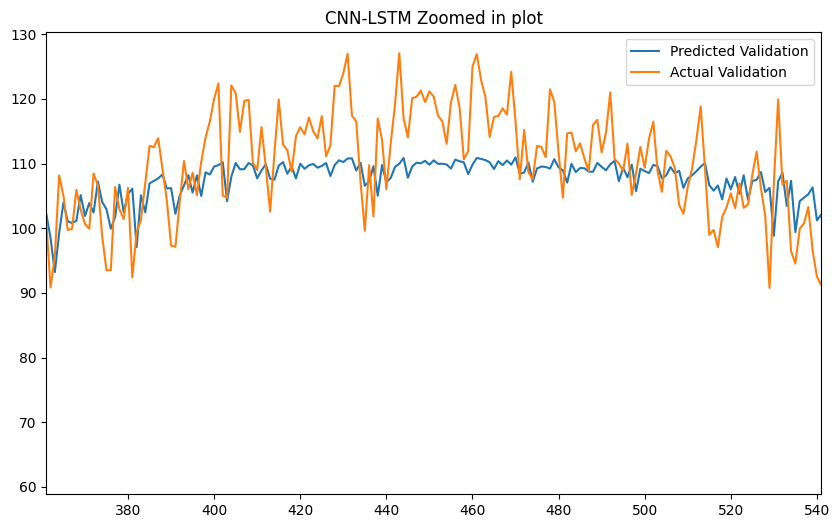

In [11]:
start_date = "2022-01-01"
end_date = "2022-06-30"
plot_predictions(forecast, y_val, title="CNN-LSTM Zoomed in plot", start_date=start_date, end_date=end_date)
